In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score

from utils import predict_with_threshold, print_coefficients, coefficients_to_prediction

# Step 1: Explore the data

In [2]:
# Read in the diabetes dataset
diabetes_data = pd.read_csv("data/diabetes.csv")
diabetes_data.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,tested_positive
1,1,85,66,29,0,26.6,0.351,31,tested_negative
2,8,183,64,0,0,23.3,0.672,32,tested_positive
3,1,89,66,23,94,28.1,0.167,21,tested_negative
4,0,137,40,35,168,43.1,2.288,33,tested_positive


In [3]:
# Get some basic information about the dataset
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    768 non-null    int64  
 2   pres    768 non-null    int64  
 3   skin    768 non-null    int64  
 4   insu    768 non-null    int64  
 5   mass    768 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    object 
dtypes: float64(2), int64(6), object(1)
memory usage: 54.1+ KB


class
tested_negative    500
tested_positive    268
Name: count, dtype: int64


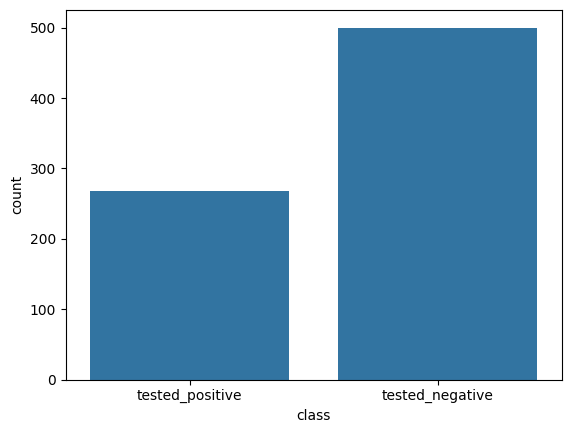

In [4]:
sns.countplot(data=diabetes_data, x="class")
print(diabetes_data["class"].value_counts())

# Prepare the data for training

In [5]:
# Convert the target variable to categorical
class_mapping = {'tested_negative': 0, "tested_positive": 1}
diabetes_data["class"] = diabetes_data["class"].map(class_mapping).astype(int)
diabetes_data.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# Separate features and label
features = diabetes_data.drop(columns=["class"])
label = diabetes_data["class"]
features.head()

,preg,plas,pres,skin,insu,mass,pedi,age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


# Train a model

In [7]:
clf = LogisticRegression(max_iter=1000)
clf.fit(features, label)

print(f"Classifier trained for {clf.n_iter_[0]} iterations")

Classifier trained for 196 iterations


# Explore Model Predictions

In [8]:
first_five_predictions = clf.predict(features.head()).tolist()
print(f"First five predictions: {first_five_predictions}")

First five predictions: [1, 0, 1, 0, 1]


In [9]:
first_five_probabilities = clf.predict_proba(features.head())[:, 1].tolist()
first_five_probabilities = [round(prob, 4) for prob in first_five_probabilities]
print(f"First five probabilities: {first_five_probabilities}")

First five probabilities: [0.7194, 0.0493, 0.7926, 0.0427, 0.8897]


In [10]:
decision_threshold = 0.5
predictions = [int(probability > decision_threshold) for probability in first_five_probabilities]
print(f"First five predictions (threshold={decision_threshold}): {predictions}")


First five predictions (threshold=0.5): [1, 0, 1, 0, 1]


# Evaluate the model?

In [11]:
def accuracy_score(predictions: np.ndarray, labels: pd.Series) -> float:
    correct = sum(predictions == labels)
    return correct / len(labels)

In [12]:
accuracy_score(clf.predict(features), label)
print(f"Training accuracy: {round(accuracy_score(clf.predict(features), label) * 100, 2)}%")

Training accuracy: 78.12%


## Accuracy treats both classes as equally important. That's not always true

In [13]:
recall = float(recall_score(label, clf.predict(features)))

print(f"Training recall: {round(recall * 100, 2)}%")

Training recall: 58.21%


# How will accuracy and recall respond to changes in the decision threshold?

In [14]:
threshold = 0.99999
predictions = predict_with_threshold(clf, features, threshold=threshold)
recall = float(recall_score(label, predictions))
accuracy = accuracy_score(np.array(predictions), label)

print(f"Training accuracy (threshold={decision_threshold}): {round(accuracy * 100, 2)}%")
print(f"Training recall (threshold={decision_threshold}): {round(recall * 100, 2)}%")

Training accuracy (threshold=0.5): 65.1%
Training recall (threshold=0.5): 0.0%


In [15]:
sum(label == 0) / len(label)  # Proportion of negative class

0.6510416666666666

# What happens if I use a different model?

In [16]:
tree_clf = DecisionTreeClassifier()
tree_clf.fit(features, label)

print("Decision tree classifier trained.")

Decision tree classifier trained.


In [17]:
tree_predictions = tree_clf.predict(features)
accuracy_score(tree_predictions, label)
recall = float(recall_score(label, tree_predictions))

print(f"Training accuracy (decision tree): {round(accuracy_score(tree_predictions, label) * 100, 2)}%")
print(f"Training recall (decision tree): {round(recall * 100, 2)}%")

Training accuracy (decision tree): 100.0%
Training recall (decision tree): 100.0%


# Extra if we can be bothered

In [18]:
print_coefficients(features.columns, clf.coef_)

,feature,coefficient,odds_ratio
0,preg,0.122516,1.130338
1,plas,0.035111,1.035735
2,pres,-0.013299,0.986789
3,skin,0.000783,1.000783
4,insu,-0.001174,0.998827
5,mass,0.089646,1.093787
6,pedi,0.867924,2.381961
7,age,0.014980,1.015093


In [19]:
coefficients_to_prediction(intercept=clf.intercept_, coefficients=clf.coef_, X=features.iloc[0])

array([0.71943835])

In [20]:
clf.predict_proba(features.head())[:, 1].tolist()

[0.7194383492004656,
 0.04928903826618515,
 0.7925965877061558,
 0.0427315172722701,
 0.8896609485261553]

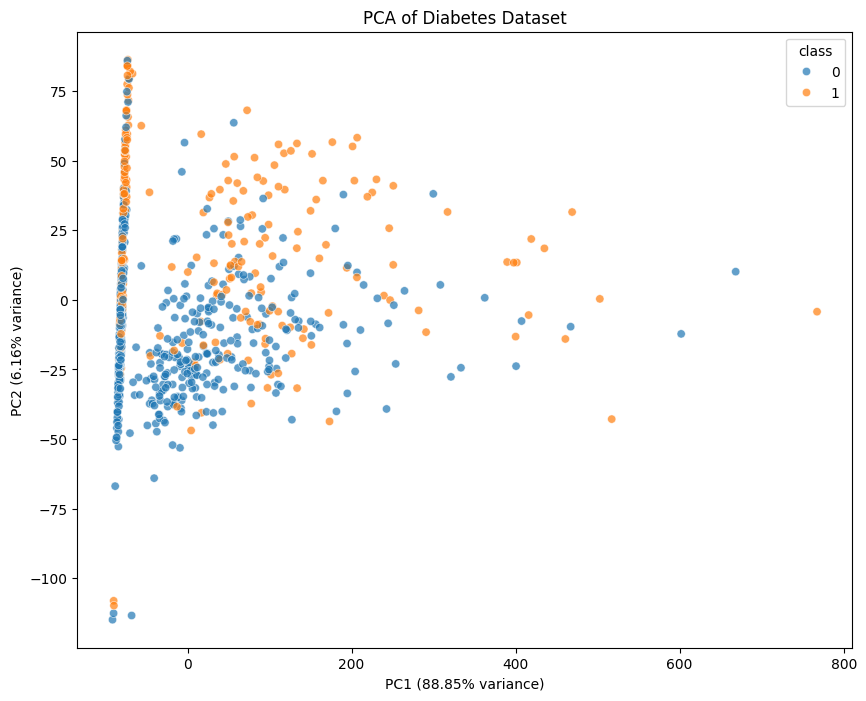

PC1 explains 88.85% of the variance
PC2 explains 6.16% of the variance
Together they explain 95.01% of the variance


In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA on the features (X already excludes the class variable)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(features)

# Create a dataframe with PCA components and class labels
pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'class': diabetes_data['class']
})


# Create scatterplot with class as hue
plt.figure(figsize=(10, 8))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='class', alpha=0.7)
plt.title('PCA of Diabetes Dataset')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.show()

print(f"PC1 explains {pca.explained_variance_ratio_[0]:.2%} of the variance")
print(f"PC2 explains {pca.explained_variance_ratio_[1]:.2%} of the variance")
print(f"Together they explain {sum(pca.explained_variance_ratio_):.2%} of the variance")

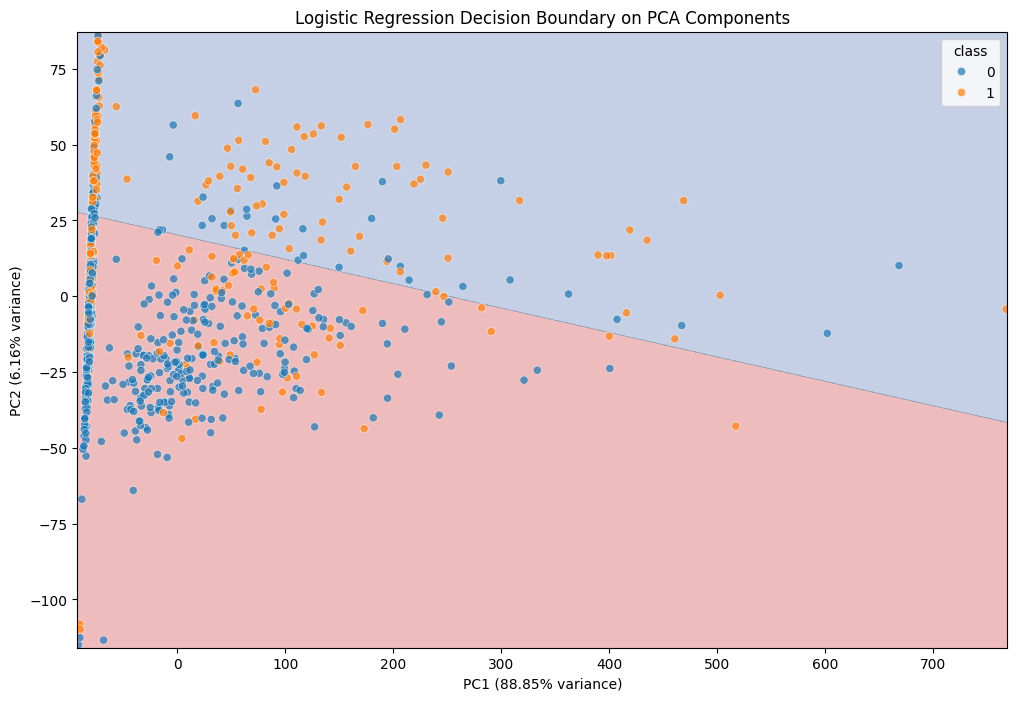

In [22]:
# Create a mesh grid for decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Train logistic regression on PCA components
clf_pca = LogisticRegression(max_iter=1000)
clf_pca.fit(X_pca, label)

# Predict on the mesh grid
Z = clf_pca.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Create the plot
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='class', alpha=0.7)
plt.title('Logistic Regression Decision Boundary on PCA Components')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.show()

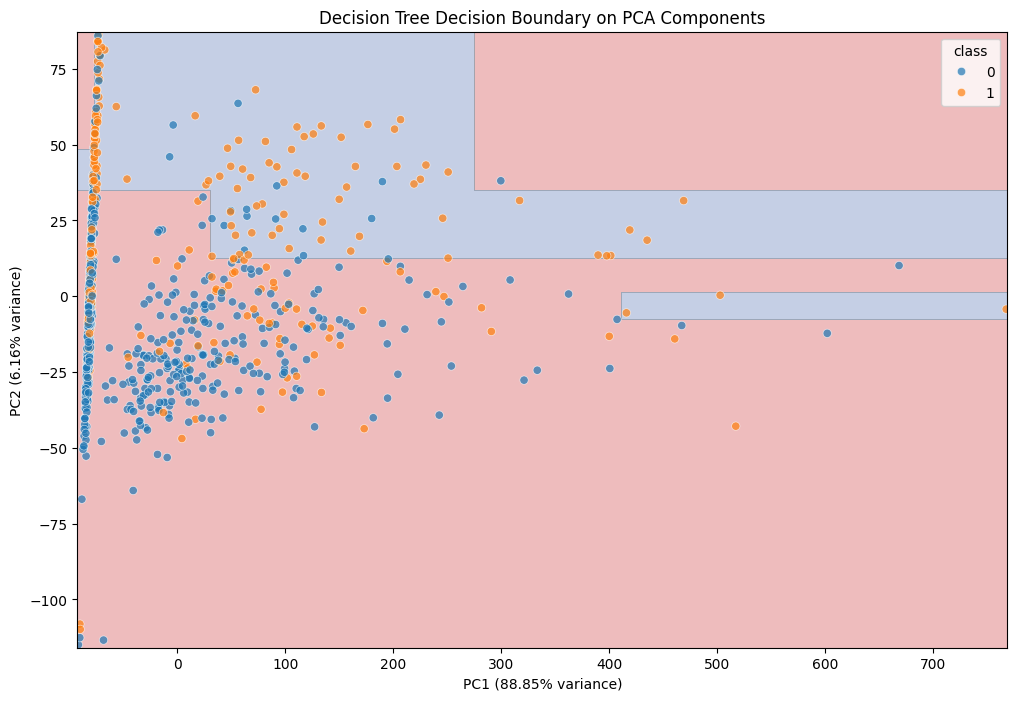

In [23]:
from sklearn.tree import DecisionTreeClassifier

# Train a decision tree on the PCA components
tree = DecisionTreeClassifier(max_depth=4, random_state=42)  # tweak depth as you like
tree.fit(X_pca, label)

# Predict on the mesh grid
Z = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Plot
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.RdYlBu)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='class', alpha=0.7)
plt.title('Decision Tree Decision Boundary on PCA Components')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.show()
